In [1]:
from math import sqrt

import numpy as np

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import skimage
from skimage import io, exposure, img_as_float, img_as_ubyte, morphology, filters, util
from skimage.color import rgb2gray, label2rgb
from skimage.feature import canny, blob_dog, blob_log, blob_doh,  peak_local_max
from skimage.filters import sobel, threshold_otsu, try_all_threshold, threshold_local, threshold_minimum
from skimage.segmentation import clear_border, watershed, random_walker
from skimage.measure import label, regionprops
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from skimage.morphology import closing
from skimage.io import imsave, imread

import cv2

from scipy import ndimage as ndi
from scipy.stats import norm

import os

import plotly.graph_objs as go

import platform

In [2]:
#image_filename = '/Users/carolinemccue/Desktop/MG63/r01c03f60p02-ch2sk1fk1fl1.jpg'
#image_filename = '/Users/carolinemccue/Desktop/MG63/r01c03f53p02-ch2sk1fk1fl1.tiff'
#image_filename = '/Users/carolinemccue/Desktop/MG63/r01c03f17p02-ch2sk1fk1fl1.tiff'
image_filename = '/Users/carolinemccue/Desktop/MG63/r01c03f25p03-ch2sk1fk1fl1.tiff'

if os.path.isdir(image_filename):
    img_list = [os.path.join(image_filename,f) for f in os.listdir(image_filename) if f.endswith('.jpg')]
elif os.path.isfile(image_filename):
    img_list = [image_filename]

for image_file in img_list:
        image = cv2.imread(image_file, 0)

In [3]:
x = 0
out_directory = "MG6310_" + str(x)
while os.path.exists(out_directory):
    x = int(os.path.basename(out_directory).split('_')[1])
    x += 1
    out_directory = "MG6310_" + str(x)
os.mkdir("MG6310_" + str(x))

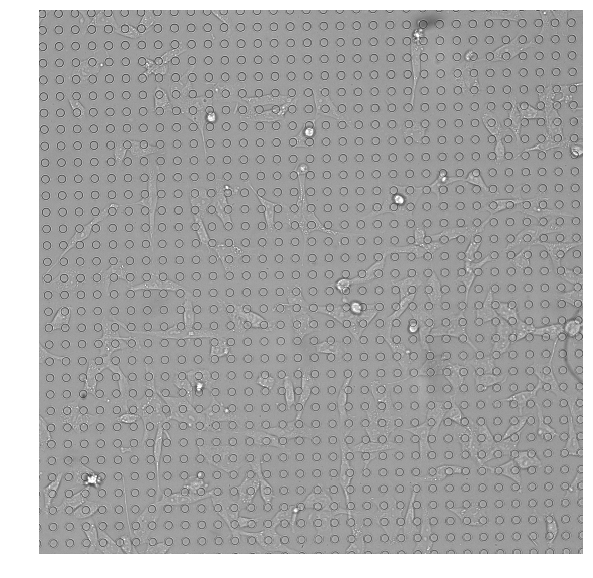

In [4]:
fig = plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(image, cmap=plt.cm.gray, vmin=0, vmax=255, interpolation='nearest')

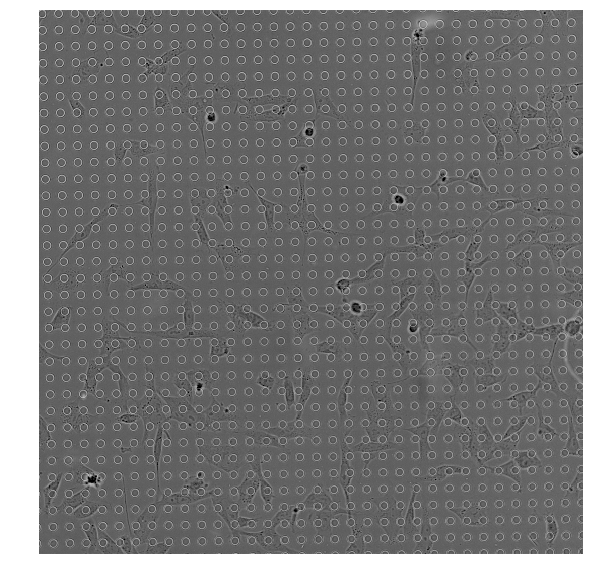

In [5]:
image = np.invert(image)
fig = plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(image, cmap=plt.cm.gray, vmin=0, vmax=255, interpolation='nearest')

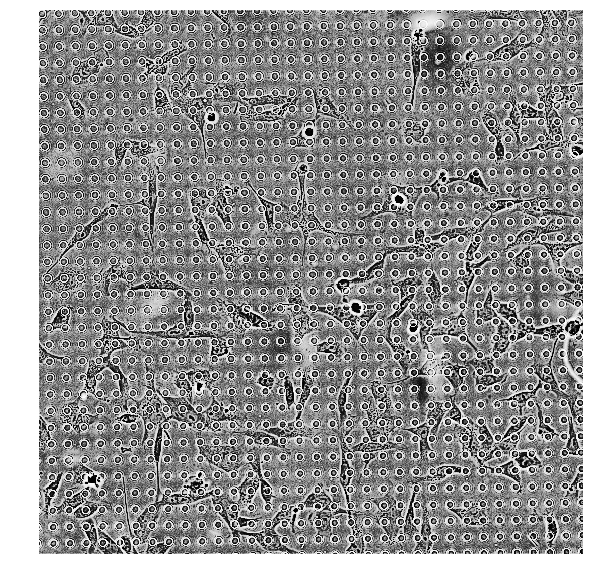

In [6]:
# Adaptive Equalization
clahe = cv2.createCLAHE(clipLimit=20, tileGridSize=(10,10))
img_adapteq = clahe.apply(image)
fig = plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img_adapteq, cmap=plt.cm.gray, interpolation='nearest')

Minimum threshold: 70.0
Min intensity: 0
Max intensity: 255


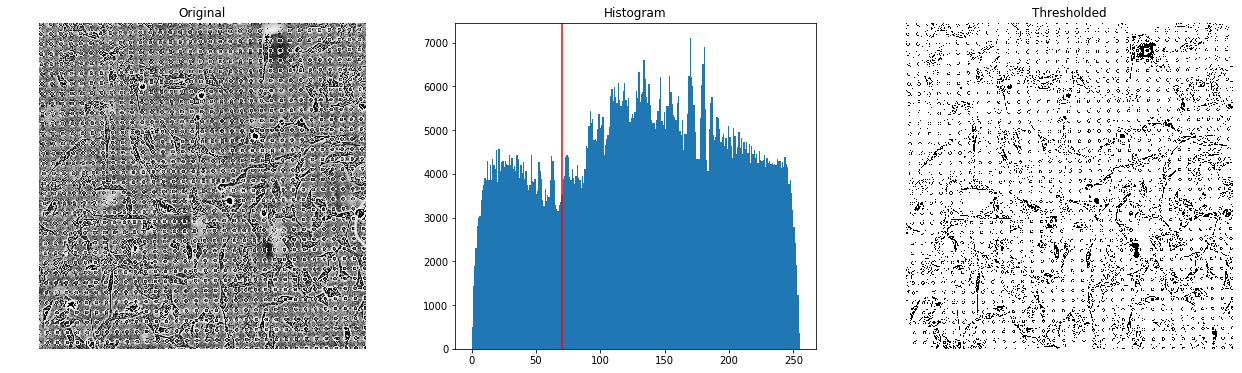

In [7]:
image = img_adapteq

blur = cv2.GaussianBlur(image,(3,3),0)
retVal, binary = cv2.threshold(blur,70,255,cv2.THRESH_BINARY)

fig, axes = plt.subplots(ncols=3, figsize=(22, 6))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(image.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(retVal, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

print('Minimum threshold: ' + str(retVal))
print('Min intensity: ' + str(np.min(image)))
print('Max intensity: ' + str(np.max(image)))
plt.show()

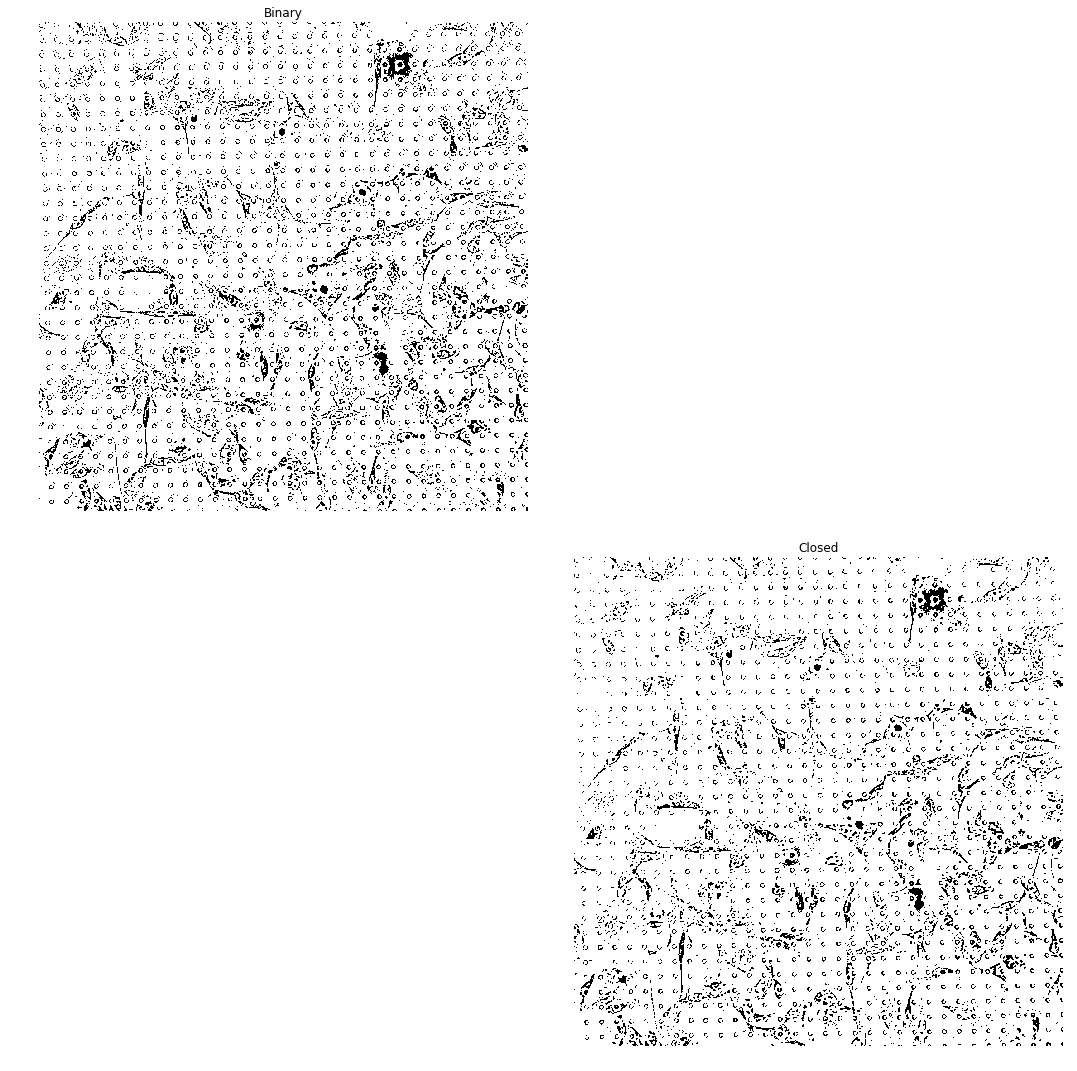

In [8]:
from skimage.morphology  import binary_closing, disk, binary_dilation, remove_small_holes, remove_small_objects
#fill_holes = ndi.morphology.binary_fill_holes(binary, structure=np.ones((15,15))).astype('uint8')

#remove_posts = morphology.remove_small_objects(binary, 20)
#remove_posts = morphology.remove_small_holes(remove_posts, 20)
#remove_posts = remove_posts.astype(np.uint8)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2,2))
closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations = 1)


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
ax = axes.ravel()

ax[0].imshow(binary, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('Binary')
#ax[1].imshow(fill_holes, cmap=plt.cm.gray, interpolation='nearest')
#ax[1].set_title('Fill Holes')
#ax[2].imshow(remove_posts, cmap=plt.cm.gray, interpolation='nearest')
#ax[2].set_title('Removed posts')
ax[3].imshow(closed, cmap=plt.cm.gray, interpolation='nearest')
ax[3].set_title('Closed')


for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()
#plt.savefig("2_thresh_close.jpg")

In [9]:
closed=np.invert(closed)

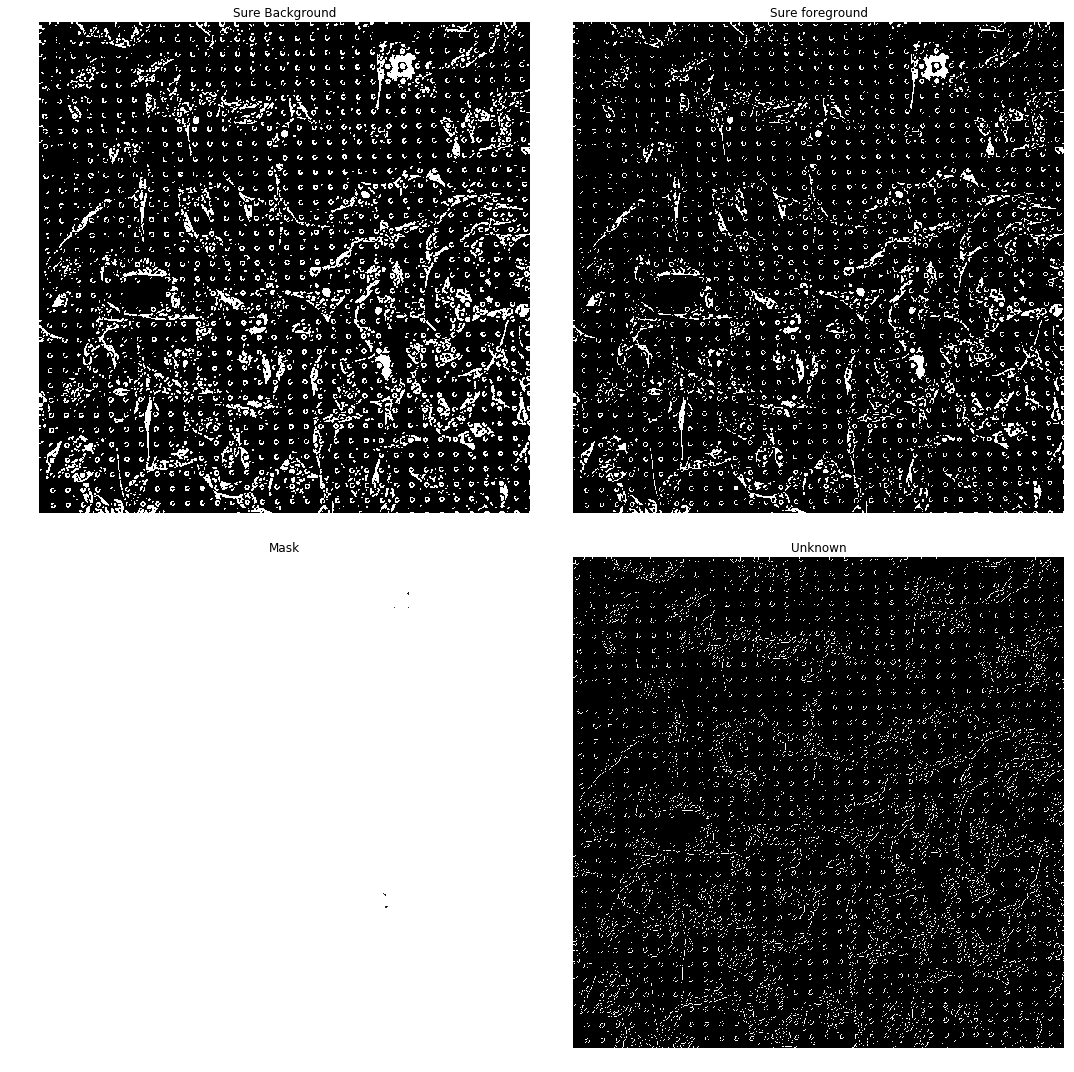

In [10]:
# noise removal
kernel = np.ones((2,2),np.uint8)
#opening = cv2.morphologyEx(closed,cv2.MORPH_OPEN,kernel, iterations = 2)
closing = cv2.morphologyEx(closed, cv2.MORPH_CLOSE, kernel, iterations = 2)
# sure background area
#sure_bg = cv2.dilate(opening,kernel,iterations=3)
sure_bg = cv2.dilate(closing,kernel,iterations=1)
# Finding sure foreground area
#dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
dist_transform = cv2.distanceTransform(closing,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.1*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

mask = dist_transform.copy()
mask[mask < 8] = 0

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
ax = axes.ravel()

ax[0].imshow(sure_bg, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('Sure Background')
ax[1].imshow(sure_fg, cmap=plt.cm.gray, interpolation='nearest')
ax[1].set_title('Sure foreground')
ax[2].imshow(-mask, cmap=plt.cm.gray, interpolation='nearest')
ax[2].set_title('Mask')
ax[3].imshow(unknown, cmap=plt.cm.gray, interpolation='nearest')
ax[3].set_title('Unknown')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

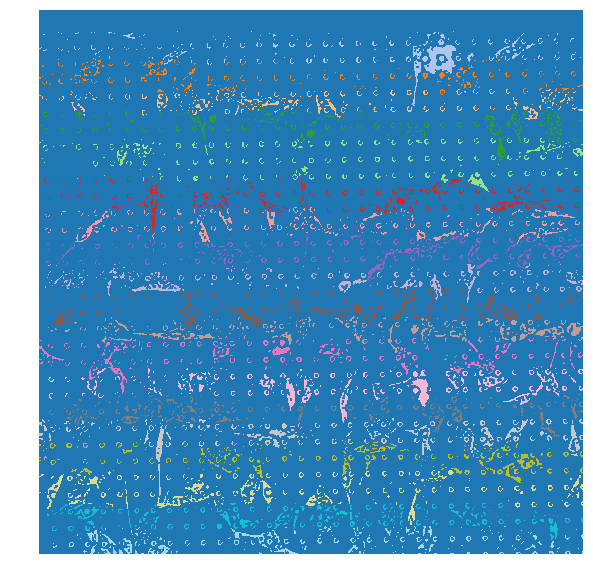

In [11]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

markers = markers+1
markers[unknown>0] = 0

fig = plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(markers, cmap=plt.cm.tab20)

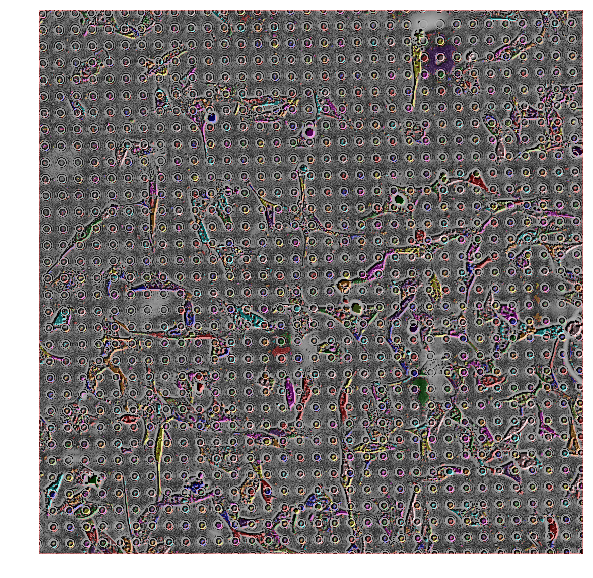

In [12]:
threeChannels = cv2.cvtColor(closed, cv2.COLOR_GRAY2BGR)
segmented = cv2.watershed(threeChannels.astype('uint8'), markers)

# Color the labels sections for display
image_label_overlay = label2rgb(segmented, image, bg_label=1)
fig = plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(image_label_overlay)

In [13]:
reg = regionprops(segmented, intensity_image=image)[1:]
cellreg = [region for region in reg if (region.area) > 100 and (region.area) < 25000]
columns= ['Label', 'Area', 'Eccentricity', 'Circularity', 'Bbox Area', 'Bbox', 'Centroid', 'Image', 'Long Axis', 'Short Axis']
df = pd.DataFrame(columns=columns, dtype=np.float64)
df = df.append([{'Label':i.label, 'Area':i.area, 'Eccentricity':i.eccentricity, 'Circularity':(4 * np.pi * i.area / (i.perimeter**2)), 'Bbox Area':i.bbox_area, 'Bbox':i.bbox, 'Centroid':i.centroid, 'Image':i.intensity_image, 'Long Axis':i.major_axis_length, 'Short Axis':i.minor_axis_length} for i in cellreg])
df.head(5)

Label   Area  Eccentricity  Circularity  Bbox Area                Bbox  \
0    8.0  130.0      0.987493     0.283534  1166400.0   (1, 346, 29, 376)   
1   38.0  257.0      0.976552     0.114546  1166400.0   (5, 892, 22, 949)   
2   65.0  120.0      0.787290     0.329720  1166400.0  (12, 203, 31, 220)   
3  180.0  165.0      0.857857     0.304441  1166400.0  (41, 748, 65, 764)   
4  193.0  116.0      0.892239     0.330420  1166400.0  (45, 167, 57, 191)   

                                  Centroid  \
0  (13.646153846153846, 359.2846153846154)   
1  (16.019455252918288, 921.6459143968872)   
2              (21.866666666666667, 211.7)   
3  (52.236363636363635, 755.8484848484849)   
4  (51.01724137931034, 179.86206896551724)   

                                               Image  Long Axis  Short Axis  
0  [[128, 194, 201, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  43.664636    6.884220  
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  64.919598   13.975862  
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 90, 130, 0, 0, 0,...  20.164863   12.433310  
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 8, 192, ...  24.984027   12.839013  
4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  23.386445   10.560476

In [14]:
df['Area'].median(), df['Area'].mean()

(174.0, 237.88359788359787)

189 cells were detected and segmented
92 cells with selected criteria


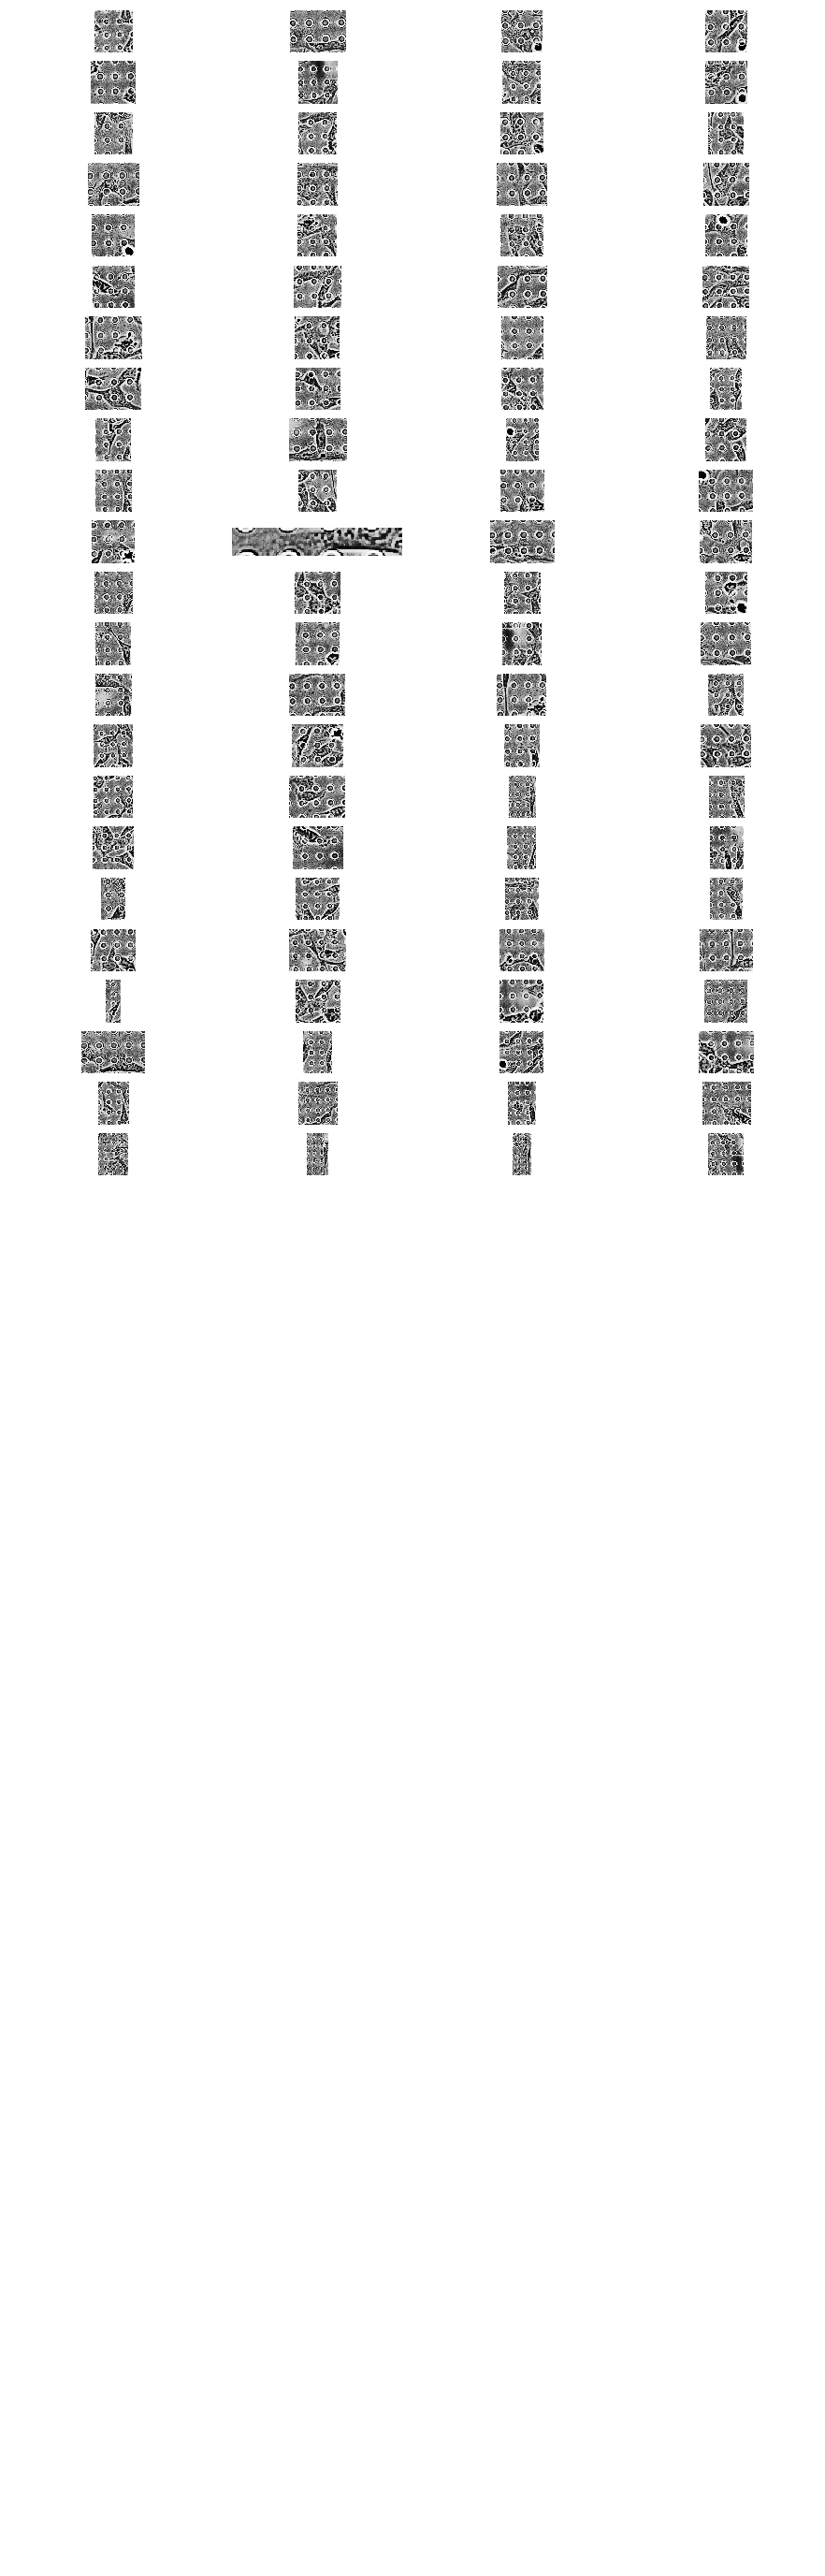

In [15]:
# Display parameters
org_img = image # Intensity image
border = 75 # Additional pixels to display on each side of the bounding box
ecc_cutoff = 0.05 # circularity cuttoff, removes background circles
ecc_cutoff_upper = 1
area_cutoff_upper = 5*df.Area.mean() # Area cuttoff, removes misidentified shapes (for instance half-droplets)
area_cutoff_lower = 1*df.Area.median()
max_col = org_img.shape[1]
max_row = org_img.shape[0]

n_img = len(cellreg)
print("{} cells were detected and segmented".format(n_img))
n_col = 50
n_rows = n_img // n_col + 1

cellreg.sort(key=lambda x: x.area)
cellreg_clean = [region for region in cellreg if (region.area) > area_cutoff_lower and (region.area) < area_cutoff_upper and region.eccentricity > ecc_cutoff and region.eccentricity < ecc_cutoff_upper]

print("{} cells with selected criteria".format(len(cellreg_clean), area_cutoff_lower, area_cutoff_upper))

fig, ax = plt.subplots(n_col, n_rows)
axes = ax.ravel()

for i, region in enumerate(cellreg_clean):
    (min_row, min_col, max_row, max_col) = region.bbox
    drop_image = org_img[np.max([min_row-border,0]):np.min([max_row+border,max_row]),np.max([min_col-border,0]):np.min([max_col+border,max_col])]
    contrast_stretch = exposure.rescale_intensity(drop_image, in_range=(0,255))
    name = os.path.join(out_directory, os.path.basename(image_file).split('.')[0] + '_cell_' + str(i) + '.jpg')
    imsave(name, contrast_stretch, check_contrast=False)
    axes[i].imshow(contrast_stretch, cmap=plt.cm.gray, interpolation='nearest', vmin=0, vmax=255)
    axes[i].axis('off')
    
for i in range(n_col*n_rows - len(cellreg_clean)):
    axes[-(i+1)].axis('off')
    
fig.set_size_inches(15, 50)

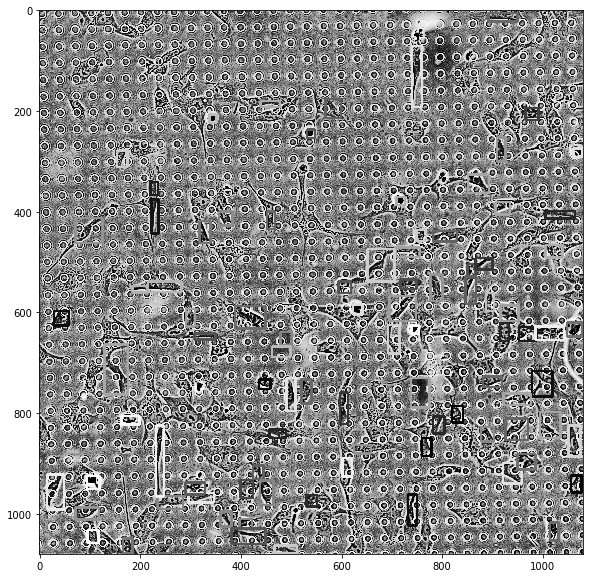

In [16]:
boxed_regions = image.copy()
for region in cellreg_clean:
    (min_row, min_col, max_row, max_col) = region.bbox
    color = np.uint8(np.random.randint(0, 255, 3)).tolist()
    cv2.rectangle(boxed_regions, (min_col,min_row), (max_col,max_row), color, 3)
    #cv2.putText(boxed_regions,'%d'%region.label,(min_col+50, min_row+100), cv2.FONT_HERSHEY_SIMPLEX, 3, color, 3, cv2.LINE_AA)
    
fig = plt.figure(figsize=(15,10))
plt.imshow(boxed_regions, cmap=plt.cm.gray)

In [17]:
columns= ['Label', 'Area', 'Eccentricity', 'Circularity', 'Bbox Area', 'Bbox', 'Centroid', 'Image', 'Long Axis', 'Short Axis']
df2 = pd.DataFrame(columns=columns, dtype=np.float64)
df2 = df2.append([{'Label':i.label, 'Area':i.area, 'Eccentricity':i.eccentricity, 'Circularity':(4 * np.pi * i.area / (i.perimeter**2)), 'Bbox Area':i.bbox_area, 'Bbox':i.bbox, 'Centroid':i.centroid, 'Image':i.intensity_image, 'Long Axis':i.major_axis_length, 'Short Axis':i.minor_axis_length} for i in cellreg_clean])
df2.tail(5)

Label   Area  Eccentricity  Circularity  Bbox Area                  Bbox  \
87  1909.0  673.0      0.949763     0.118207  1166400.0  (587, 389, 632, 449)   
88  2218.0  739.0      0.913313     0.062773  1166400.0  (664, 130, 763, 176)   
89   273.0  744.0      0.991829     0.066855  1166400.0   (71, 740, 192, 760)   
90  2784.0  820.0      0.995873     0.097834  1166400.0  (824, 232, 965, 248)   
91  2426.0  972.0      0.903858     0.337277  1166400.0  (730, 738, 789, 775)   

                                   Centroid  \
87    (611.372956909361, 419.9717682020802)   
88  (709.9688768606225, 154.83761840324763)   
89  (117.68548387096774, 749.3938172043011)   
90  (877.8719512195122, 239.63536585365853)   
91   (754.7438271604939, 760.5216049382716)   

                                                Image   Long Axis  Short Axis  
87  [[4, 27, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...   67.694249   21.186201  
88  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  105.999551   43.169288  
89  [[0, 0, 0, 75, 111, 0, 0, 0, 185, 45, 0, 0, 0,...  123.537138   15.760146  
90  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 78, 237,...  137.608902   12.489821  
91  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 43, 3...   62.283988   26.647084

In [18]:
areaum10 = df2['Area'] / 1.5503 ** 2
celllength10 = df2['Long Axis'] / 1.5503
circularity10 = df2['Circularity']
aspectratio10 = df2['Short Axis']/df2['Long Axis']
areaum10.mean(), areaum10.std()

(137.3716027156259, 64.86156278454393)

In [19]:
%store areaum10
%store circularity10
%store celllength10
%store aspectratio10

Stored 'areaum10' (Series)
Stored 'circularity10' (Series)
Stored 'celllength10' (Series)
Stored 'aspectratio10' (Series)
